In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import numpy as np
import warnings
from sklearn.model_selection import cross_val_score, StratifiedKFold
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv', encoding = "utf-8", sep = '\t', decimal = ',')
test = pd.read_csv('test.csv', encoding = "utf-8", sep = '\t', decimal = ',')

for col in df.select_dtypes(include=['object']).columns:
    if col != 'y':
        df[col] = df[col].astype('category')
        test[col] =  test[col].astype('category')
        
df['target'] = 0
df.loc[df.y == 'yes', 'target'] = 1
df.drop('y', axis = 1, inplace = True)

feat = ['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

Обучим на 10 страт. фолдах, качество усредним

In [3]:
def get_model():
    return lgb.LGBMClassifier(nthread=4, boosting_type= 'gbdt', is_unbalance= True,random_state = 42,
            learning_rate= 0.1, max_depth= 3, reg_lambda=0.1 , reg_alpha= 0.01, min_child_samples= 20, 
            metric= 'auc', n_estimators= 5000)  
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')
feature_importance_df = pd.DataFrame()
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds_idx = [(train_idx, val_idx) for train_idx, val_idx in folds.split(df[feat], y=df['target'])]

Fold  1 AUC : 0.947397
Fold  2 AUC : 0.917245
Fold  3 AUC : 0.935278
Fold  4 AUC : 0.944007
Fold  5 AUC : 0.933615
AUC: 0.9355085696267202 std: 0.010495146154016767


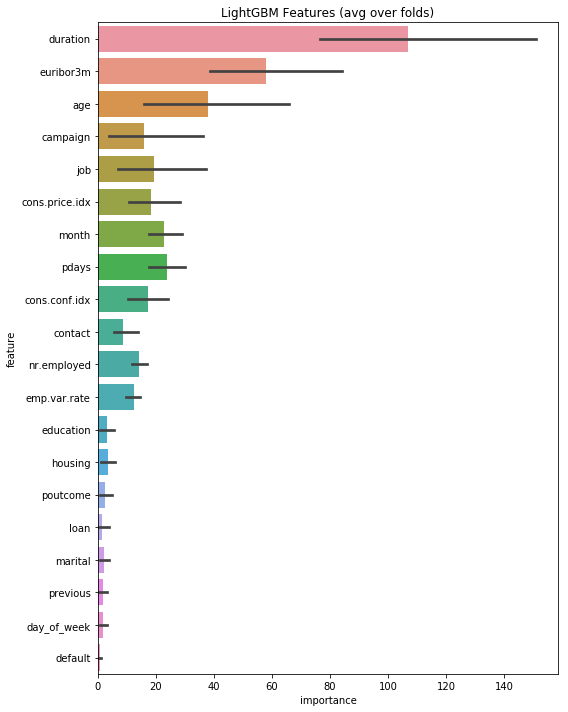

In [4]:
auc_scores = []
oof_preds = np.zeros(df[feat].shape[0])
test_preds = []
final_preds = np.zeros(test.shape[0])
for n_fold, (train_idx, valid_idx) in enumerate(folds_idx):

    train_x, train_y = df[feat].iloc[train_idx], df['target'].iloc[train_idx]
    valid_x, valid_y = df[feat].iloc[valid_idx], df['target'].iloc[valid_idx]
    
    clf = get_model()
    clf.fit(train_x, train_y, 
            eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc', verbose=False, early_stopping_rounds=200)
       
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]   
    auc_scores.append(roc_auc_score(valid_y, oof_preds[valid_idx]))
    y_pred = clf.predict_proba(test[feat], num_iteration=clf.best_iteration_)[:, 1]
    final_preds += y_pred
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feat
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, auc_scores[-1]))
print( 'AUC:', np.mean(auc_scores), 'std:', np.std(auc_scores))
final_preds = final_preds/5
display_importances(feature_importance_df)

Проверим фичи с помощью null permutation test. Отберем фичи

In [5]:
keep = 0; delet_feat = 0; num_fold = 5;
to_refit = True
trun_feat = feat.copy()
for val in feat:
    #print(val)
    auc_scores = []; auc_scores_wo = [];
    for n_fold, (train_idx, valid_idx) in enumerate(folds_idx):
        train_x, train_y2 = df[trun_feat].iloc[train_idx], df['target'].iloc[train_idx]
        valid_x, valid_y = df[trun_feat].iloc[valid_idx], df['target'].iloc[valid_idx]
        if to_refit:
            clf = get_model()
            clf.fit(train_x, train_y2, 
                    eval_set=[(train_x, train_y2), (valid_x, valid_y)], 
                    eval_metric='auc', verbose=False, early_stopping_rounds=100)        
        auc_scores.append(roc_auc_score(valid_y, clf.predict_proba(valid_x)[:, 1]))
        valid_x_null = valid_x.copy()
        valid_x_null[val] = np.NaN
        if val in train_x.select_dtypes(include=['category']).columns:
            valid_x_null[val] = valid_x_null[val].astype('category')
        auc_scores_wo.append(roc_auc_score(valid_y, clf.predict_proba(valid_x_null)[:, 1]))
        
    auc_w = np.mean(auc_scores);  auc_wo = np.mean(auc_scores_wo);
    if  auc_w - auc_wo <= 0.001:     
        #print('Deleted feature: ', val, '. Diff AUC:', auc_w - auc_wo)
        delet_feat +=1
        to_refit = True
        trun_feat.remove(val) 
    else:
        #print( val, 'wAUC: ', auc_w, ' woAUC: ', auc_wo ,auc_w - auc_wo, "keep")
        to_refit = False
        keep += 1
print('deleted:', delet_feat,', kept: ' , keep)

deleted:  8 , kept:  12


Добавим агрегаций по  средним показателям топ признака *duration* для топ категорий. Сделаем отбор как выше

In [6]:
total = df.append(test)
agr1 = total[['duration', 'job', 'month']].groupby(['month'], as_index=False).agg(['mean']) 
agr2 = total[['duration', 'job', 'month']].groupby(['job'], as_index=False).agg(['mean']) 
agr1.columns = ['month_mean_duration']; agr2.columns = ['job_mean_duration'];

df = df.merge(agr1, how = 'inner', left_on='month', right_index = True)
test = test.merge(agr1, how = 'inner', left_on='month', right_index = True)
df = df.merge(agr2, how = 'inner', left_on='job', right_index = True)
test = test.merge(agr2, how = 'inner', left_on='job', right_index = True)

df['durat-job_mean_duration'] = df['duration'] - df['job_mean_duration']
df['durat-month_mean_duration'] = df['duration'] - df['month_mean_duration']
test['durat-job_mean_duration'] = test['duration'] - test['job_mean_duration']
test['durat-month_mean_duration'] = test['duration'] - test['month_mean_duration']
addit_feat  = ['durat-job_mean_duration', 'month_mean_duration', 'job_mean_duration', 'month_mean_duration']
for val in addit_feat: trun_feat.append(val)
    
trun_feat = ['job',
 'contact',
 'month',
 'duration',
 'pdays',
 'emp.var.rate',
 'euribor3m',
 'durat-job_mean_duration']

Обучим модель на оставшихся признаках и сделаем предикты

In [17]:
def get_model():
    return lgb.LGBMClassifier(nthread=4, boosting_type= 'gbdt', is_unbalance= True,random_state = 42,
            learning_rate= 0.1, max_depth= 4, reg_lambda=0.1 , reg_alpha= 0.03, min_child_samples= 20, 
            metric= 'auc', n_estimators= 5000)  
feat = trun_feat
feature_importance_df = pd.DataFrame()
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds_idx = [(train_idx, val_idx) for train_idx, val_idx in folds.split(df[feat], y=df['target'])]
auc_scores = []
oof_preds = np.zeros(df[feat].shape[0])
test_preds = []
final_preds = np.zeros(test.shape[0])
for n_fold, (train_idx, valid_idx) in enumerate(folds_idx):

    train_x, train_y = df[feat].iloc[train_idx], df['target'].iloc[train_idx]
    valid_x, valid_y = df[feat].iloc[valid_idx], df['target'].iloc[valid_idx]
    
    clf = get_model()
    clf.fit(train_x, train_y, 
            eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc', verbose=False, early_stopping_rounds=200)
       
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]   
    auc_scores.append(roc_auc_score(valid_y, oof_preds[valid_idx]))
    y_pred = clf.predict_proba(test[feat], num_iteration=clf.best_iteration_)[:, 1]
    final_preds += y_pred
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feat
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, auc_scores[-1]))
print( 'AUC:', np.mean(auc_scores), 'std:', np.std(auc_scores))
final_preds = final_preds/5
#display_importances(feature_importance_df)

preds = pd.DataFrame({'ID': test.index, 'y': final_preds})
preds.to_csv('predicts.csv', index=None, decimal=',', header=True)

Fold  1 AUC : 0.927136
Fold  2 AUC : 0.938165
Fold  3 AUC : 0.935679
Fold  4 AUC : 0.942089
Fold  5 AUC : 0.949240
AUC: 0.9384617712956753 std: 0.007285998519244323


In [ ]:
Уменьшили std, увеличили AUC